# Analysis of the results

In [1]:
import sys
sys.path.append("..")

from analysis.analysis_utils import extract_all_info_from_hdf5, get_phenotype_table_from_parameters
from analysis.dataset import Dataset
from analysis.link_measure import compute_mean_xhis, phenotype_discriminated_response
from analysis.pattern_measure import measure_frequency_diadic_pattern, measure_global_frequency_triadic_pattern, \
                                measure_diadic_pattern_combination, measure_triadic_pattern_phenotype_combination
from plot.dataset_plot import plot_hist_by_phenotype, plot_bar_diadic_pattern, plot_triadic_pattern_phenotype, \
                                plot_phenotype_combination_per_link, plot_phenotype_combination_per_triangle
from plot.plot import plot_xhi_by_phenotype, plot_cooperation_per_phenotype
import matplotlib.pyplot as plt
import numpy as np

### Extracting all information from file

In [2]:
filepath = r"../out/E3O2P21R12T17_S75_T0.6_M1000_N1000000//E3O2P21R12T17_S75_T0.6_M1000_N1000000.h5"
adj_matrices, parameters = extract_all_info_from_hdf5(filepath)
niter = parameters["Number of interaction"]
phenotype_table = get_phenotype_table_from_parameters(parameters)

In [3]:
local_dt = Dataset('local')
local_dt.init_with_matrices(adj_matrices, parameters, niter)

/home/yuxuama/Dev/Python/reinforcing_learning_social/notebook/../analysis/link_measure.py:80: RuntimeWarning: invalid value encountered in divide
  xhi = histogram / L


### Analysis per phenotype

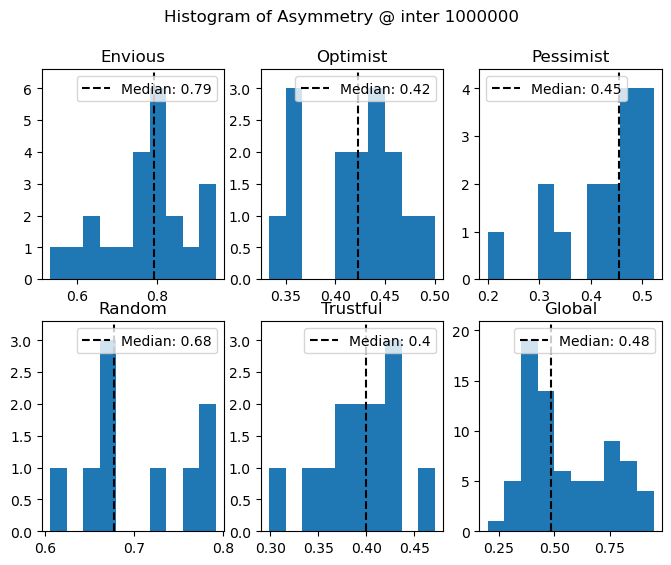

In [4]:
plot_hist_by_phenotype(local_dt, "Asymmetry")
plt.show()

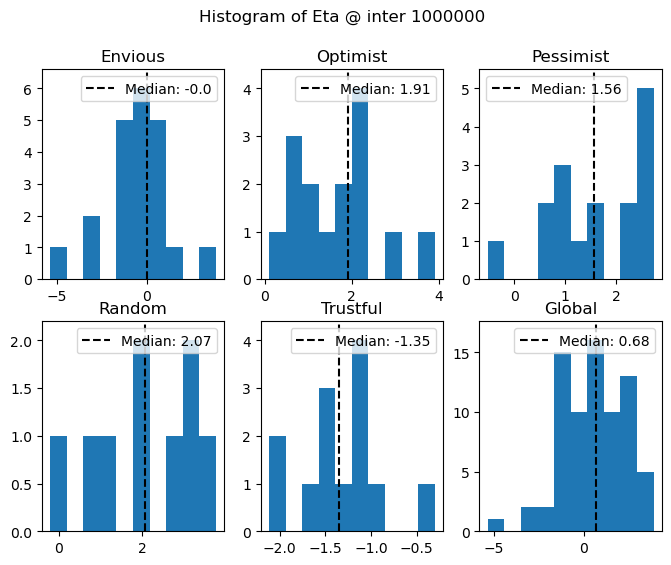

In [5]:
plot_hist_by_phenotype(local_dt, 'Eta')
plt.show()

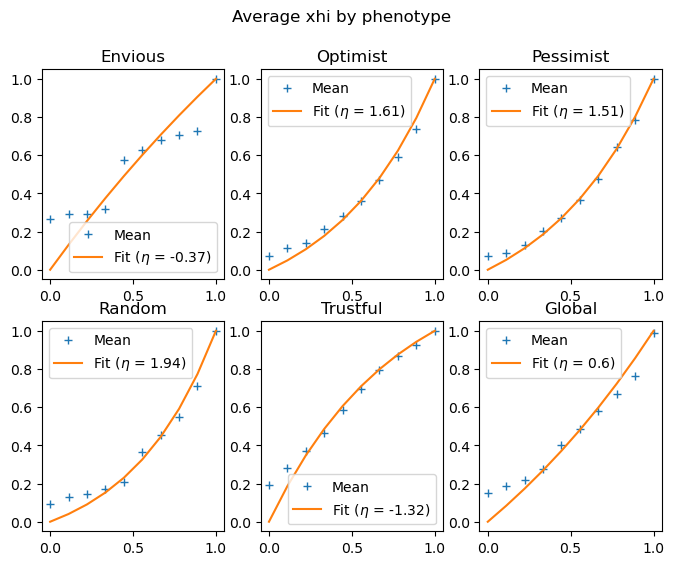

In [6]:
xhis = compute_mean_xhis(adj_matrices["peTotal"], parameters["Trust threshold"], phenotype_table)
plot_xhi_by_phenotype(xhis)
plt.show()

### Per game analysis

In [7]:
game_signature = "PD"

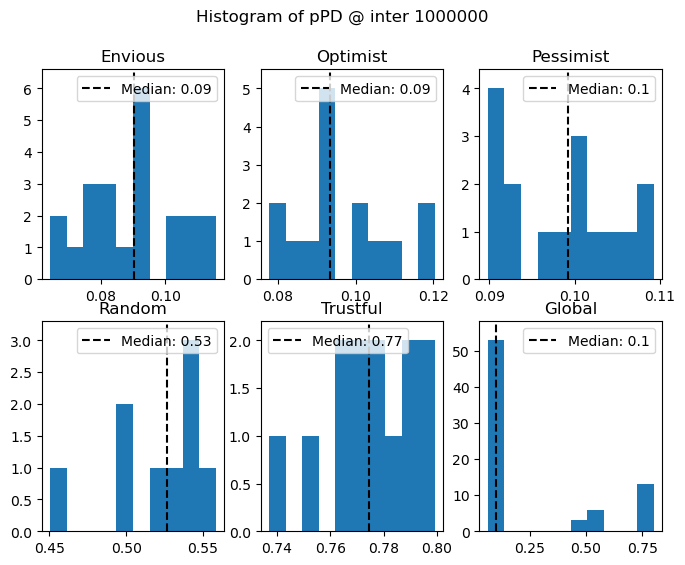

In [8]:
plot_hist_by_phenotype(local_dt, "p" + game_signature)
plt.show()

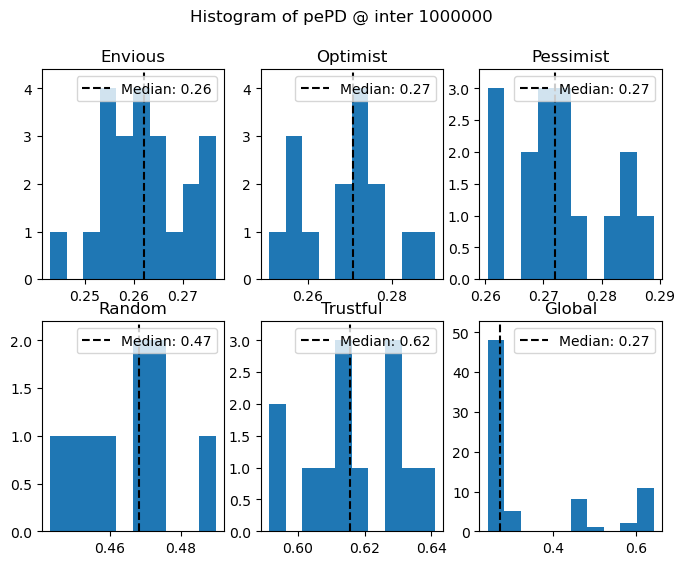

In [9]:
plot_hist_by_phenotype(local_dt, "pe" + game_signature)
plt.show()

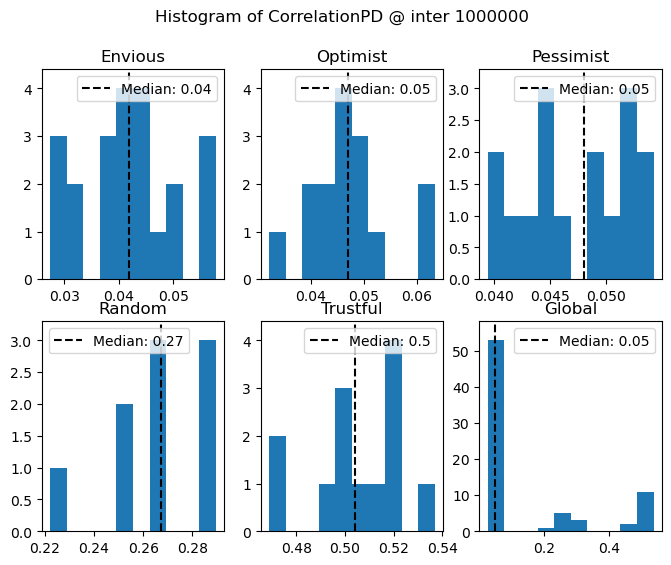

In [10]:
plot_hist_by_phenotype(local_dt, "Correlation" + game_signature)
plt.show()

### Versus per phenotype

In [11]:
responses = phenotype_discriminated_response(adj_matrices, phenotype_table)

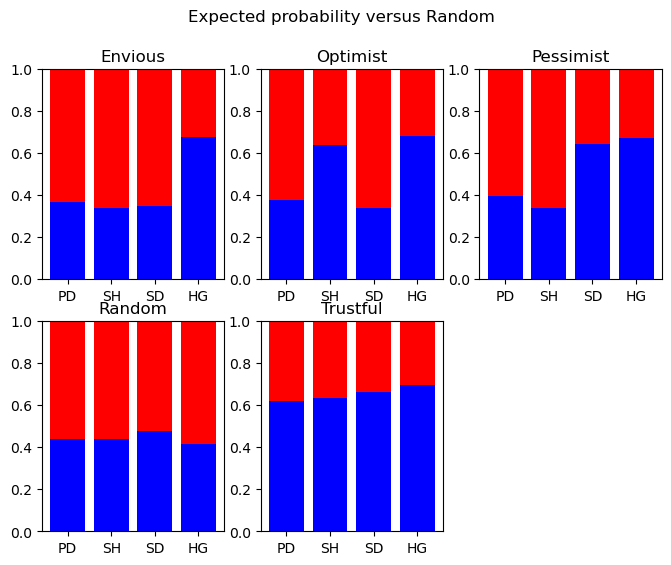

In [22]:
plot_cooperation_per_phenotype(responses, "Random", expected=True)
plt.show()

### Diadic pattern

In [13]:
diadic_pattern = measure_frequency_diadic_pattern(adj_matrices["link"], parameters, niter)

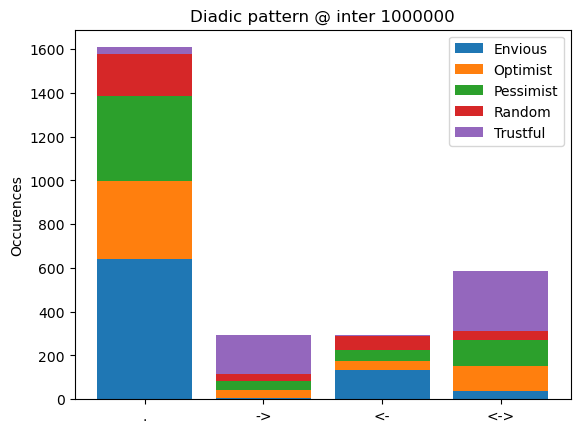

In [14]:
plot_bar_diadic_pattern(diadic_pattern)
plt.show()

In [15]:
link_phenotype_combination = measure_diadic_pattern_combination(adj_matrices["link"], phenotype_table, niter)

<Axes: title={'center': 'Phenotype combinations distribution for -> with threshold 10'}, ylabel='Occurence'>

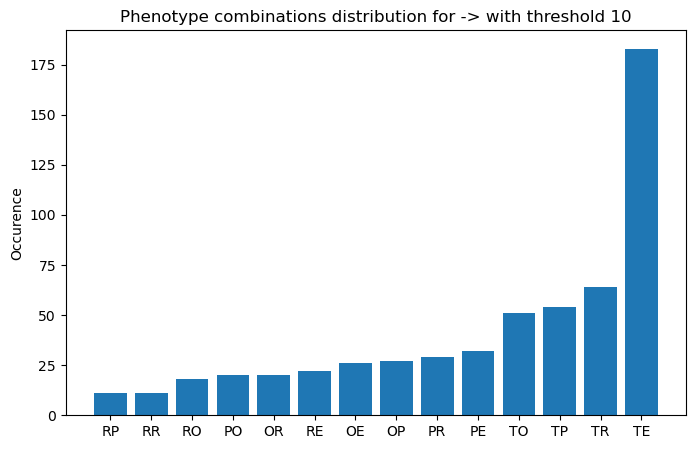

In [16]:
plot_phenotype_combination_per_link("->", link_phenotype_combination, th=10)

### Triadic pattern

In [17]:
triadic_pattern = measure_global_frequency_triadic_pattern(adj_matrices["link"], parameters, niter)

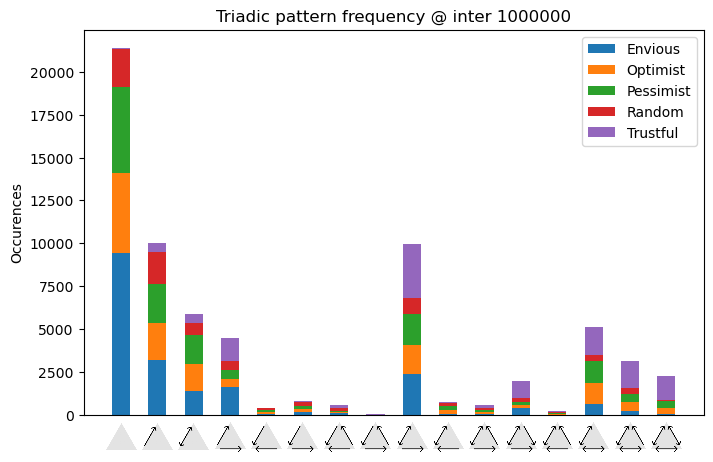

In [18]:
plot_triadic_pattern_phenotype(triadic_pattern, parameters)
plt.show()

In [19]:
triangle_phenotype_combination = measure_triadic_pattern_phenotype_combination(adj_matrices["link"], parameters, niter)

<Axes: title={'center': 'Phenotype combinations distribution for triangle 112112 with threshold 20'}, ylabel='Occurence'>

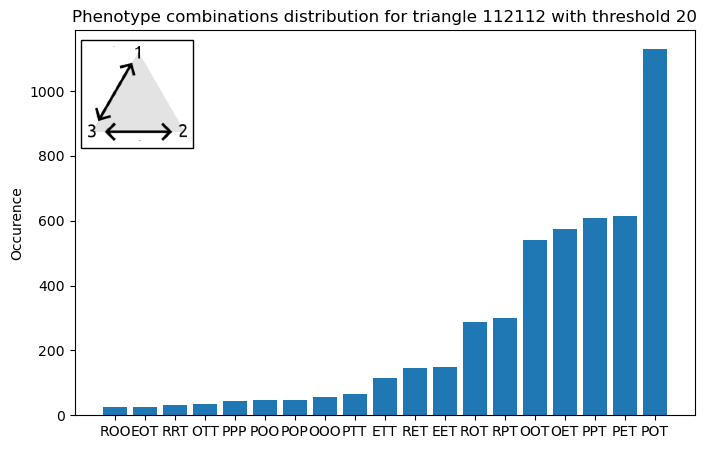

In [20]:
plot_phenotype_combination_per_triangle("112112", triangle_phenotype_combination, 20)